# 地方競馬（NAR）高度な相対・状況適性特徴量導入モデル (12モデル)

ノートブック 11 の LambdaRank モデルをベースに、レース内での相対的な強さや状況適性（馬場状態、季節等）を考慮した特徴量を追加しました。

### 追加した特徴量
1. **レース内相対指標**: `weighted_si_momentum_race_rank`, `zscore` 等。
2. **状況適性**: `horse_state_place_rate` (馬場状態別実績), `season`, `is_night_race`。
3. **人間系の勢いバイアス**: `trainer_momentum_bias` (直近30日 vs 通年平均)。

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
import lightgbm as lgb
from scipy.stats import spearmanr

# プロジェクトのsrcディレクトリをパスに追加
src_path = os.path.abspath(os.path.join(os.getcwd(), '../../src'))
if src_path not in sys.path:
    sys.path.append(src_path)

from nar.loader import NarDataLoader
from nar.features import NarFeatureGenerator

%matplotlib inline
sns.set(font='IPAexGothic', style='whitegrid')

/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py:18: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from optuna import progress_bar as pbar_module


In [2]:
loader = NarDataLoader()
raw_df = loader.load(limit=150000, region='south_kanto')

generator = NarFeatureGenerator(history_windows=[1, 2, 3, 4, 5])
df = generator.generate_features(raw_df)

df = df.dropna(subset=['rank']).copy()
df['date'] = pd.to_datetime(df['date'])

print(f'データ件数: {len(df)}')

重複データを削除しました: 150000 -> 143895 件


データ件数: 37346


In [3]:
baseline_features = [
    'distance', 'venue', 'state', 'frame_number', 'horse_number', 'weight', 'impost',
    'jockey_win_rate', 'jockey_place_rate', 'trainer_win_rate', 'trainer_place_rate',
    'horse_run_count'
] + [col for col in df.columns if 'horse_prev' in col]

advanced_features = [
    'gender', 'age', 'days_since_prev_race', 'weight_diff',
    'horse_jockey_place_rate', 'is_consecutive_jockey',
    'distance_diff', 'horse_venue_place_rate',
    'trainer_30d_win_rate',
    'impost_diff', 'was_accident_prev1', 'weighted_si_momentum', 'weighted_rank_momentum',
    'class_rank', 'class_diff', 'is_promoted', 'is_demoted'
]

phase9_features = [
    'weighted_si_momentum_race_rank', 'weighted_si_momentum_diff_from_avg', 'weighted_si_momentum_zscore',
    'weighted_rank_momentum_race_rank', 'weighted_rank_momentum_diff_from_avg', 'weighted_rank_momentum_zscore',
    'class_rank_race_rank', 'class_rank_diff_from_avg', 'class_rank_zscore',
    'horse_state_place_rate', 'season', 'is_night_race', 'trainer_momentum_bias'
]

features = list(set(baseline_features + advanced_features + phase9_features))

# カテゴリ変数の処理
categorical_cols = ['venue', 'state', 'gender', 'season']
for col in features:
    if col in df.columns:
        if col in categorical_cols:
            df[col] = df[col].astype(str).astype('category')
        else:
            df[col] = pd.to_numeric(df[col], errors='coerce')

# 不要な列の削除（念のため）
features = [f for f in features if f in df.columns]

split_date = df['date'].quantile(0.8)
train_df = df[df['date'] < split_date].copy()
test_df = df[df['date'] >= split_date].copy()

print(f'訓練データ: {len(train_df)}')
print(f'テストデータ: {len(test_df)}')

訓練データ: 29819
テストデータ: 7527


In [4]:
train_df = train_df.sort_values('race_id')
test_df = test_df.sort_values('race_id')

train_groups = train_df.groupby('race_id').size().values
test_groups = test_df.groupby('race_id').size().values

train_label = 20 - train_df['rank']
test_label = 20 - test_df['rank']

model = lgb.LGBMRanker(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=64,
    max_depth=6,
    random_state=42,
    importance_type='gain'
)

model.fit(
    train_df[features], train_label,
    group=train_groups,
    eval_set=[(test_df[features], test_label)],
    eval_group=[test_groups],
    eval_at=[1, 3, 5],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7184
[LightGBM] [Info] Number of data points in the train set: 29819, number of used features: 58
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

LGBMRanker(importance_type='gain', learning_rate=0.05, max_depth=6,
           n_estimators=1000, num_leaves=64, random_state=42)

In [5]:
test_df['pred_score'] = model.predict(test_df[features])
correlation, _ = spearmanr(test_df['pred_score'], test_df['rank'])
print(f'Spearman順位相関係数: {correlation:.4f}')

test_df['pred_rank'] = test_df.groupby('race_id')['pred_score'].rank(method='min', ascending=False)

eval_list = []
for r in range(1, 6):
    matches = test_df[test_df['pred_rank'] == r]
    win_rate = (matches['rank'] == 1).mean()
    place_rate = (matches['rank'] <= 3).mean()
    eval_list.append({'predicted_rank': r, 'win_rate': win_rate, 'place_rate': place_rate})

eval_df = pd.DataFrame(eval_list)
print('\n予測順位別 的中率:')
print(eval_df)

Spearman順位相関係数: -0.4297

予測順位別 的中率:
   predicted_rank  win_rate  place_rate
0               1  0.264026    0.587459
1               2  0.157377    0.439344
2               3  0.130795    0.408940
3               4  0.097360    0.334983
4               5  0.087748    0.311258


<Figure size 1000x1200 with 0 Axes>

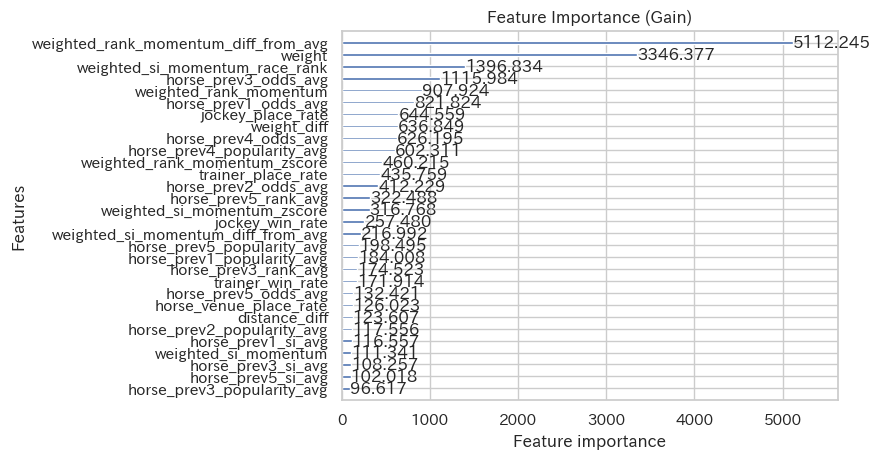

In [6]:
plt.figure(figsize=(10, 12))
lgb.plot_importance(model, max_num_features=30, importance_type='gain')
plt.title('Feature Importance (Gain)')
plt.show()